In [23]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import hermite, factorial
from numpy.typing import NDArray


import ipywidgets as widgets
from IPython.display import display

import seaborn as sns
rcparams = {
    "font.size": 22,        # suptitle size (upper most)
    "axes.titlesize": 18,   # fig title size (below suptitle)
    "axes.labelsize": 15,   # x,y label size
    "xtick.labelsize": 12,  # x tick label size
    "ytick.labelsize": 12,  # y tick label size
    "legend.fontsize": 15,  # legend font size
    "figure.figsize": (10, 6),  # figure size
    "image.cmap": "RdBu_r", # set default colormap for images (maybe also contour plots)
}
sns.set_theme(context="notebook", style="darkgrid", rc=rcparams, font_scale=2, palette="colorblind")


# Reconstruction

## Read data

In [24]:
# load data arrays
data = np.load("measurements.npz")
thetas = data["thetas"]
measurements = data["samples"]

# print data 
with np.printoptions(precision=2, linewidth=150, edgeitems=3, suppress=True):
    print(f"      thetas {thetas.shape}:", thetas)
    print(f"measurements {measurements.shape}:", measurements)

# print metadata
with open("measurements_metadata.txt") as f:
    metadata = f.read()
    print("Metadata:")
    print(metadata)

      thetas (12,): [0.   0.26 0.52 0.79 1.05 1.31 1.57 1.83 2.09 2.36 2.62 2.88]
measurements (12, 100000): [[-2.27 -2.49 -2.11 ...  3.08 -2.22  2.6 ]
 [ 3.56 -3.77  3.88 ...  3.4   2.7   2.81]
 [ 2.81 -3.18  3.88 ...  3.88 -2.76 -2.86]
 ...
 [-1.58 -0.29  1.74 ...  0.94  1.95 -0.72]
 [-1.74 -1.9  -0.29 ...  2.17 -2.7  -0.67]
 [ 1.69 -1.53 -2.6  ... -2.22  1.42  2.11]]
Metadata:
state_type,cat
parity,even
alpha,(2+1j)
N_cutoff,30
thetas [radians],[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976, 1.308996938995747, 1.5707963267948966, 1.832595714594046, 2.0943951023931953, 2.356194490192345, 2.617993877991494, 2.8797932657906435]



### Avoid overwriting files by changing this ground truth state name:

In [25]:
state_type = "cat"

### Plot histogram of data 

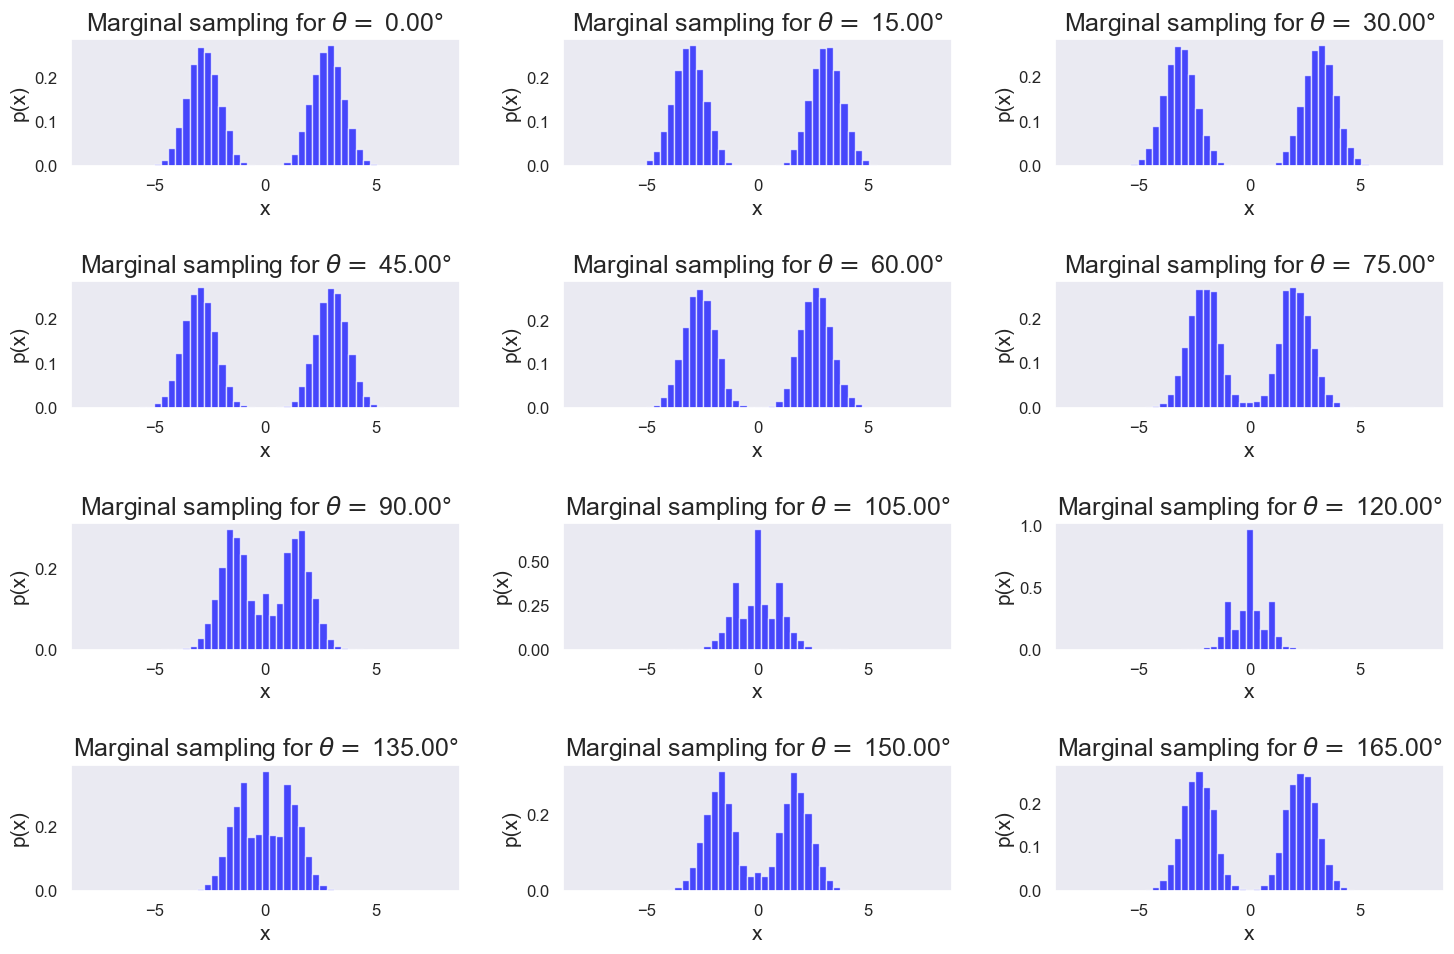

In [26]:
ncols = 3
nrows = len(thetas) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

axes = axes.flatten() if nrows > 1 else [axes]
for i, ax in enumerate(axes):
    ax.hist(x=measurements[i], bins=np.linspace(-8, 8, 50), density=True, alpha=0.7, color='blue')
    ax.set_title(f"Marginal sampling for $\\theta =$ {np.rad2deg(thetas[i]):.2f}°")
    ax.set_xlabel("x")
    ax.set_ylabel("p(x)")
    ax.grid()
    
fig.tight_layout()


### Load ground truth state

In [27]:
groundtruth = qt.fileio.qload("generated_state")
groundtruth

Quantum object: dims=[[30], [1]], shape=(30, 1), type='ket', dtype=Dense
Qobj data =
[[ 1.16083083e-01+1.57005682e-16j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 2.46249406e-01+3.28332541e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-1.65867521e-01+5.68688644e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-5.06160847e-01+1.90351088e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-3.04662701e-01-1.94244151e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-1.44422801e-02-1.89882468e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 6.23374724e-02-5.46095989e-02j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 3.00540138e-02+6.33924517e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 4.18314868e-03+8.98750254e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-1.33772121e-03+2.49788274e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-7.18425672e-04+1.09921442e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-1.20728565e-04-1.18354695e-04j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 4.73433391e-06-3.56662707e-05j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 6.

The homodyne tomography experiment gives a set of data $(X_\theta, \theta)$  -- see [A. I. Lvovsky](../references/RevModPhys.81.299.pdf)

The data is generated in the [generateState notebook](generateState.ipynb) and save to the [data file](measurements.npz) and the [meta data file](measurements_metadata.txt)

### Reconstruction using Maximum Likelihood Estimator 

<!-- 

Based on [A. I. Lvovsky - section III.B](../references/RevModPhys.81.299.pdf)

The probability of measuring $X_\theta$ from a density matrix $\hat{\rho}$ is $\mathrm{P}_\rho(X_\theta) = \mathrm{Tr}\left[\hat{\Pi}(X_\theta)\hat{\rho}\right]$ where $\hat{\rho}$ is density matrix and $X_\theta$ is the measurement.

The maximum likelihood estimator is the density matrix maximizing the (log)-likelihood:

$$
    \hat{\rho}_0 = \max_{\rho}{\left(\ln{\mathcal{L}}\right)}.
$$

We determine the optimal $\hat{\rho}_0$, the one maximizing the likelihood, iteratively as
$$
    \hat{\rho}^{(k+1)} =  \dfrac{\hat{R}\rho^{k}\hat{R}}{\mathrm{Tr}\left[\hat{R}\rho^{k}\hat{R}\right]}, 
$$
with rho being normalized to a unitary trace.

The operator $\hat{\Pi}(X_\theta) = \ket{X_\theta}\bra{X_\theta}$ is the project operator of our measurement state.

The iteration operator is defined as:
$$
    \hat{R} = \sum_i \dfrac{\hat{\Pi}(X_{\theta_i})}{P_\rho(X_{\theta_i})},
$$

and the log-likelihood for continous variables is defined as:

$$
    \ln\mathcal{L} = \sum_i \ln{P_\rho(X_\theta)}.
$$

but for discretized data we need to bin the data, and determine the frequency of the data being in some bin, and then we can determine the likelihood:

$$
    \mathcal{L}(\hat{\rho}) = \prod_j P_\rho(X_{\theta_j})^{f(X_{\theta_j})}
$$


Note: The notation $X_{\theta_j}$ is to be understood as the measurement of $\left(X_j, \theta_j\right)$ from the Homodyne Tomography experiment.
 -->


For reconstruction of the Wigner function from the dataset $\mathcal{D}(X_\theta, \theta)$ containing samples, we use the iterative maximum-likelihood method described in: [A. I. Lvovsky 2004, J. Opt. B: Quantum Semiclass. Opt. 6 S556](https://iopscience.iop.org/article/10.1088/1464-4266/6/6/014). 

We will for the most part use the same notation as in the article.

The likelihood of the state being in $\hat{\rho}$ is given by

$$
\begin{align}
    \mathcal{L}(\hat{\rho}) = \prod_j p(X_j,\theta_j \vert \hat{\rho})^{f(X_j,\theta_j)}

\end{align}
$$
Here $j$ signifies the $j$'th bin of data for some angle $\theta$, $p_\rho(j)$ is the probability of a measurement being in said bin for a density matrix $\rho$, and $f_j$ is the *frequency* of measurements in bin $j$, or how many measurements are in the bin.

We want to determmine the optimal density matrix, $\hat{\rho}_\mathrm{opt}$, which maximizes the likelihood.

We can iterate the density matrix by

$$
\begin{align}
    \hat{\rho}^{(k+1)} &= \dfrac{\hat{R}\hat{\rho}^{(k)}\hat{R}}{\mathrm{Tr}\left[\hat{R}\hat{\rho}^{(k)}\hat{R}\right]} 
    \\
    \hat{R} = \hat{R}(\hat{\rho}) &= \sum_j\dfrac{f(X_j,\theta_j)}{p(X_j,\theta_j\vert \hat{\rho})}\Pi_{nm}(X_j,\theta_j), \\
     \Pi_{nm}(X,\theta) &= \langle n \vert X,\theta \rangle \langle X,\theta \vert m \rangle
\end{align}
$$

with $\langle n \vert X,\theta\rangle = e^{in\theta}\langle  n\vert X, 0\rangle =  e^{in\theta}\psi_n(X)$ and $\Pi_{nm}(X,\theta)$ being the projection of the quadrature onto the Fock state, which has a well-defined solution for a harmonic potential and can be looked up online as:

$$
\begin{align}
    \psi_n(x) = \left(\dfrac{2}{\pi}\right)^{1/4} \dfrac{H_n(\sqrt{2}x)}{\sqrt{2^n n!}}e^{-x^2}
\end{align}
$$

When implementing eq. (6) we will create a state $\ket{\psi_n}$ which is a vector of length $N_\mathrm{cut}$, and compute the projection operator $\Pi_{nm}(j)$ for each value of $(X_j,\theta_j)$ and then sum over all $\Pi_{nm}$ of size $(N_\mathrm{cut}\times N_\mathrm{cut})$ calculating $\hat{R}$ in eq. (5).


## Construct wave function $\langle n \vert X_\theta, \theta\rangle$


In [28]:
def SE_sol(x : NDArray | float, theta : NDArray | float, n : int) -> NDArray | float:
    """Calculate the wavefunction for a given angle theta and Fock state n."""
    Hn = lambda x: hermite(n)(x)
    psi_n =  (2/np.pi)**0.25 / np.sqrt(2**n * factorial(n)) * Hn(x) * np.exp(-x**2) 
    return np.exp(1j * n * theta) * psi_n


def wavefunction_per_theta(bin_centers : NDArray, theta : float, N_cutoff=20) -> NDArray:
    """Calculate the wavefunction for a single angle theta.

    Args:
        bin_centers (NDArray): The bin centers for the quadrature measurements.
        theta (float): The angle for the quadrature measurements.
        N_cutoff (int): The cutoff for the number of Fock states to consider.
        verbose (bool, optional): Whether to print progress messages. Default is `False`.

    Returns:
        wf (qt.Qobj): The wavefunction  `<n|X,theta>`  for the given angle theta.
    """
    M = len(bin_centers)
    wf = np.zeros(shape=(M, N_cutoff), dtype=np.complex128)  # shape (M, N_cutoff)
    for n in range(N_cutoff):
        wf[:, n] = SE_sol(bin_centers, theta, n)
    return wf


## Bin the measurements and count data in bin for each angle

In [29]:
def X_theta_bins(measurements: NDArray, num_bins: int) -> tuple[NDArray, NDArray]:
    """Create bins for the histogram for each angle theta.
    
    Args: 
        measurements (NDArray): The measurement data.
        num_bins (int): The number of bins.
    
    Returns:
        (X_bins, bin_centers) (NDArray, NDArray): A tuple containing the bin edges and bin centers.
    """
    xmin, xmax = measurements.min(), measurements.max() # set x_range from values of X_theta
    X_bins = np.linspace(xmin, xmax, num_bins + 1) 
    bin_centers = 0.5 * (X_bins[:-1] + X_bins[1:]) # Calculate bin centers from midpoint between edges
    return X_bins, bin_centers

def get_counts(bins: NDArray, measurements: NDArray, unique_theta: NDArray) -> NDArray:
    """Get the counts for each bin in the histogram.

    Args:
        bins (NDArray): The bin edges.
        measurements (NDArray): The measurement data.
        unique_theta (NDArray): The unique theta values.

    Returns:
        NDArray: The sinogram of counts. shape (len(unique_theta), len(bins) - 1)
    """
    num_theta = unique_theta.size
    M = len(bins) - 1
    print(f"Number of unique thetas: {num_theta}, Number of bins: {M}")
    sinogram = np.zeros(shape=(num_theta, M)) # Initialize sinogram of shape (num_theta, num_bins)
    # measurements = measurements.reshape((num_theta, -1))  # Reshape to (num_theta, -1)
    for i in range(num_theta):
        sinogram[i], _ = np.histogram(measurements[i, :], bins=bins, density=False)
    return sinogram


## Diagnostics functions for POVMs (positive operator-valued measurements)

In [30]:

def dm_diagnostics(rho, N_expect=40, alpha_theory=2+2j):
    a = qt.destroy(rho.shape[0])
    tr_err = abs(rho.tr() - 1)
    herm_err = (rho - rho.dag()).norm()
    evals = np.linalg.eigvalsh(rho.full())
    purity = (rho*rho).tr().real
    a_mean = (rho * a).tr()
    n_mean = (rho * (a.dag()*a)).tr().real

    print(f"Trace error:   {tr_err:.2e}")
    print(f"Hermiticity ‖ρ-ρ†‖: {herm_err:.2e}")
    print(f"Min eigenvalue: {evals.min():.3e}, Max: {evals.max():.3f}")
    print(f"Purity Tr(ρ²):  {purity:.4f}")
    print(f"<a>:            {a_mean:.3f}  (theory {alpha_theory:.3f})")
    print(f"<n>:            {n_mean:.3f}  (theory {abs(alpha_theory)**2:.3f})")

    # Photon number distribution vs Poisson( nbar )
    nbar = abs(alpha_theory)**2
    N = rho.shape[0]
    p_n = np.array([(rho * qt.basis(N,n) * qt.basis(N,n).dag()).tr().real for n in range(N)])
    p_pois = np.array([np.exp(-nbar)*nbar**n/factorial(n) for n in range(N)])
    print("Top 10 p_n:", np.round(p_n[:10], 4))
    print("Top 10 Poisson:", np.round(p_pois[:10], 4))
    return dict(tr_err=tr_err, herm_err=herm_err, purity=purity, a_mean=a_mean, n_mean=n_mean, evals=evals)

def povm_completeness(E_bins):
    # E_bins is list of Qobj POVM elements for one theta
    S = sum(E_bins)
    err = (S - qt.qeye(S.shape[0])).norm()
    print("‖Σ_b E_b - I‖ =", err)

def compare_model_to_data(rho, E_bins, counts):
    # counts is 1D array for this theta; E_bins same length
    P = np.array([(rho*E).tr().real for E in E_bins])
    P /= P.sum()
    model = P
    data = counts / counts.sum()
    print("χ²:", np.sum((data-model)**2 / np.maximum(model,1e-12)))
    

def povm_elements(bin_centers, theta, N_cutoff, dx):
    """Return list of POVM elements E_j for bins centered at bin_centers."""
    wf = wavefunction_per_theta(bin_centers, theta, N_cutoff=N_cutoff)  # shape (M, N_cutoff)
    E_list = []
    for j in range(len(bin_centers)):
        # Construct |x,θ> in Fock basis
        ket = qt.Qobj(wf[j, :], dims=[[N_cutoff], [1]])  # column vector
        proj = ket * ket.dag()
        E_list.append(proj * dx)  # include Δx once
    return E_list

## Function Computing the iterative maximum likelihood estimation (MLE)

In [72]:

def update_density_matrix(rho : qt.Qobj, R: qt.Qobj) -> qt.Qobj:
    """Update the density matrix using the MLE formula."""
    updated_rho = R * rho * R
    updated_rho = updated_rho / updated_rho.tr()  # Normalize the updated density matrix to unit trace
    return updated_rho

def MLE_reconstruct(measurements, thetas, N_cutoff=10, n_bins=50, max_iter=200, dilute=None, sanity=False, tolerance=1e-12):
    """Maximum Likelihood Estimation (MLE) reconstruction.
    
    Args:
        measurements (ndarray): 
            The measurement data.
        thetas (ndarray): 
            The angles corresponding to the measurements.
        N_cutoff (int): 
            The cutoff for the number of Fock states to consider.
        n_bins (int): 
            The number of bins for the quadrature measurements.
        max_iter (int): 
            The maximum number of iterations for the MLE algorithm.
        dilute (float, optional): 
            The dilution factor for the update step.
            Updates density matrix as `rho = (1-dilute)*rho + dilute*update_density_matrix(rho, R)`
        sanity (bool, optional): 
            Whether to perform sanity checks.
        tolerance (float, default 1e-12): The convergence tolerance for the MLE algorithm.

    """
    bin_edges, bin_centers = X_theta_bins(measurements=measurements, num_bins=n_bins)
    unique_theta = np.unique(thetas)
    M = unique_theta.size

    # Compute the sinogram (counts per bin and angle) 
    sinogram = get_counts(bins=bin_edges, measurements=measurements, unique_theta=unique_theta)
    print(f"sinogram shape: {sinogram.shape}, unique_thetas: {unique_theta.shape}, bin_centers: {bin_centers.shape}")
    wfs = {}
    for theta in unique_theta:
        wfs[theta] = wavefunction_per_theta(bin_centers, theta, N_cutoff=N_cutoff)
    print(f"wfs shape: {len(wfs), len(wfs[0]), wfs[0][0].shape}")
    
    if sanity:
        dx = np.abs(bin_edges[0] - bin_edges[1])  # width of the bins
        povms = {theta: povm_elements(bin_centers, theta, N_cutoff, dx) for theta in unique_theta}

    
    # actual calculations
    rho = qt.qeye(N_cutoff).unit() 
    log_likelihoods = []
    rho_hist = []
    rho_hist.append(rho)  # Store the initial density matrix
    # Iterate rho until convergence or max_iter reached
    for iter in tqdm(range(max_iter), desc="MLE Iterations"):
        # initialize R
        R = qt.Qobj(np.zeros((N_cutoff, N_cutoff), dtype=complex))
        ll = 0.0
        for i, theta in enumerate(unique_theta):
            psi_theta = wfs[theta] # <n|X, theta_j>
            if sanity:
                povm_completeness(povms[theta])  # Ensure psi_theta_list is 1
                compare_model_to_data(rho, povms[theta], sinogram[i, :])  # Compare model to data
            else:
                pass
            
            for k, C in enumerate(sinogram[i, :]): # count per bin for angle theta
                if C == 0: # if zero skip to next calculation
                    continue 
                
                # Get the POVMs for the current theta
                psi = qt.Qobj(psi_theta[k])
                projection = psi.proj()  # Fock projection <n|X, theta><X,theta|m>
                prob = np.real((projection * rho).tr())
                R += C*projection/prob
                if prob < 0:
                    print(f"probability was negative for  theta, bin: {theta}, {k}  ")
                    prob = 1e-12
                    
                ll += C*np.log(prob)
        if not dilute is None:
            assert isinstance(dilute, (int, float)) and 0 < dilute <= 1, "Dilute must be a float between 0 and 1"
            rho = (1-dilute)*rho + dilute*update_density_matrix(rho, R)  # Update the density matrix using the MLE formula
        elif dilute is None:
            rho = update_density_matrix(rho, R) # Update the density matrix using the MLE formula
        else:
            raise ValueError("Dilute must be a float between 0 and 1 or None (the same as dilute=1)")
            
        
        # rho = rho / rho.tr()  # Normalize the updated density matrix
        rho_hist.append(rho)
        log_likelihoods.append(ll)
        if iter > 1:
            if np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tolerance:
                print(f"Convergence reached for {iter} iterations")
                break
    return rho, np.array(rho_hist), np.array(log_likelihoods), (bin_edges, bin_centers)

N_cutoff = 30
tol = 1e-6
recon, rho_hist, log_likelihoods, (bin_edges, bin_centers) = MLE_reconstruct(measurements, thetas, N_cutoff=N_cutoff, 
                                                                             dilute=None, sanity=False, n_bins=50, max_iter=800, tolerance=tol)


Number of unique thetas: 12, Number of bins: 50
sinogram shape: (12, 50), unique_thetas: (12,), bin_centers: (50,)
wfs shape: (12, 50, (30,))


MLE Iterations:   0%|          | 0/800 [00:00<?, ?it/s]

## Plot log-likelihoods

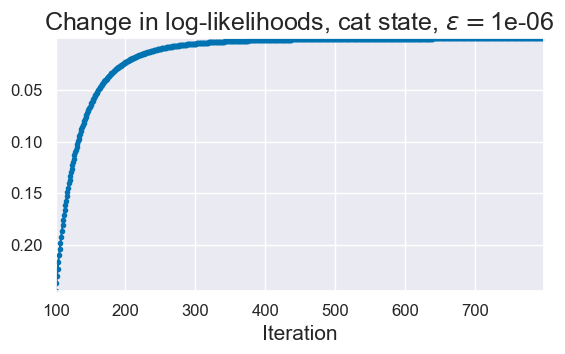

In [136]:
fig, ax = plt.subplots(figsize=(6, 4))

ll_diff = (log_likelihoods[1:] - log_likelihoods[:-1])

ax.plot(ll_diff, ".-",label="Log-likelihood")
ax.set_title(f"Change in log-likelihoods, {state_type} state, $\\epsilon =${tol}")

ax.set_xlabel("Iteration")
ax.set_xlim(100, len(ll_diff))
xmin, xmax = ax.get_xlim()
xmin = int(xmin)
xmax = int(xmax) -1
ax.set_ylim(bottom=ll_diff[xmin], top=ll_diff[xmax])

fig.tight_layout()

fig.savefig(f"plots/log_likelihoods_change_{state_type}_recon.png", dpi=250)

## Plot density matrix for reconstruction, ground truth, and their difference repectively

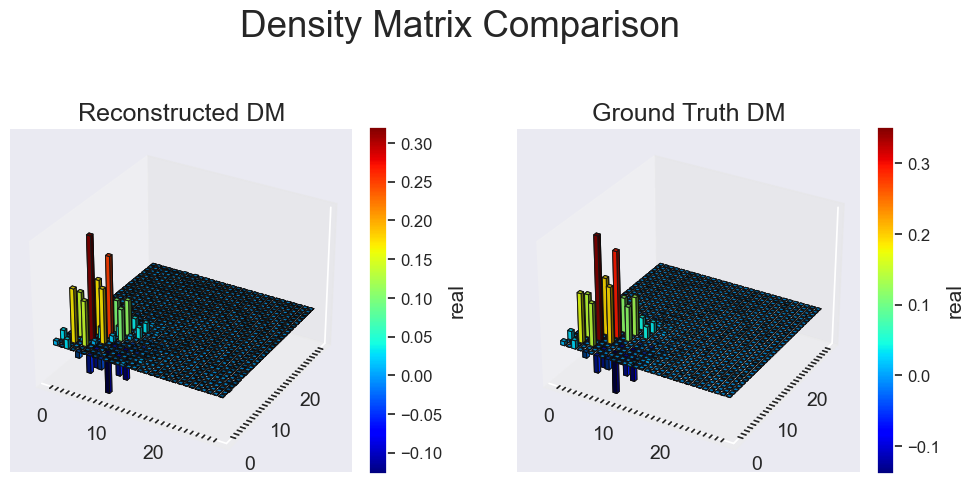

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
basis = [f"{i}" if i % 10 == 0 else " " for i in range(N_cutoff)]
bar_style = "real"
qt.matrix_histogram(recon, ax=ax1, fig=fig, x_basis=basis, y_basis=basis, bar_style=bar_style)
qt.matrix_histogram(qt.ket2dm(groundtruth), ax=ax2, fig=fig, x_basis=basis, y_basis=basis, bar_style=bar_style)

ax1.set_title("Reconstructed DM")
ax2.set_title("Ground Truth DM")
fig.suptitle("Density Matrix Comparison")
# ax3.set_title("Difference")

figname = f"plots/finals/reconstruction_comparison_DM_{state_type}.png"
fig.savefig(figname)


In [34]:
# Diagnostics of the reconstructed density matrix
with open("measurements_metadata.txt", "r") as f:
    lines = f.readlines()
    print("".join(lines))
dm_diagnostics(recon, N_expect=N_cutoff, alpha_theory=2+1j);

state_type,cat
parity,even
alpha,(2+1j)
N_cutoff,30
thetas [radians],[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976, 1.308996938995747, 1.5707963267948966, 1.832595714594046, 2.0943951023931953, 2.356194490192345, 2.617993877991494, 2.8797932657906435]

Trace error:   1.11e-16
Hermiticity ‖ρ-ρ†‖: 0.00e+00
Min eigenvalue: -1.847e-16, Max: 0.901
Purity Tr(ρ²):  0.8208
<a>:            -0.003-0.002j  (theory 2.000+1.000j)
<n>:            5.007  (theory 5.000)
Top 10 p_n: [0.0137 0.0014 0.168  0.0112 0.3206 0.0374 0.2523 0.0322 0.1094 0.0117]
Top 10 Poisson: [0.0067 0.0337 0.0842 0.1404 0.1755 0.1755 0.1462 0.1044 0.0653 0.0363]


## Compute wigner function for $\rho$ history

In [35]:
print("computing wigner functions for rho hist")
x_vec = np.linspace(-8, 8, 100)
p_vec = x_vec.copy()
wigner_functions = []
for density in tqdm(rho_hist, desc="Computing Wigner functions"):
    # Compute the Wigner function for each density matrix in rho_hist
    wigner_functions.append(qt.wigner(density, x_vec, p_vec))

computing wigner functions for rho hist


Computing Wigner functions:   0%|          | 0/801 [00:00<?, ?it/s]

### Plot interactive wigner functions and compare to ground truth

In [36]:
def update_wigner(iteration=0):
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    x_vec = np.linspace(-8, 8, 100)
    p_vec = x_vec.copy()

    cmap = "RdBu_r"
    origin = "lower"
    gt_wigner = qt.wigner(qt.ket2dm(groundtruth), x_vec, p_vec)
    
    all_max = max([gt_wigner.max(), *[w.max() for w in wigner_functions]])
    all_min = min([gt_wigner.min(), *[w.min() for w in wigner_functions]])

    vmin = np.min([all_min, -all_max])
    vmax = np.max([all_max, -all_min])
    levels = 20
    ax[1].contourf(x_vec, p_vec, gt_wigner, levels=levels, cmap=cmap, origin=origin, vmin=vmin, vmax=vmax)
    ax[1].set_title("Ground Truth Wigner Function")

    # Initial reconstruction plot
    recon_wigner = ax[0].contourf(x_vec, p_vec, wigner_functions[iteration], levels=levels, cmap=cmap, origin=origin, vmin=vmin, vmax=vmax)
    ax[0].set_title(f"Reconstruction Wigner Function (index {iteration})")
    fig.canvas.draw_idle()  # Update the figure canvas
    
# slider widget
iteration_slider = widgets.IntSlider(min=0, max=len(wigner_functions)-1, step=1, value=0, description="Iteration")
widgets.interact(update_wigner, iteration=iteration_slider)

interactive(children=(IntSlider(value=0, description='Iteration', max=800), Output()), _dom_classes=('widget-i…

<function __main__.update_wigner(iteration=0)>

### Make gif of Wigner function evolution

In [37]:
import imageio.v2 as imageio
gif_frames = []
cmap = "RdBu_r"
levels = 20
wigner_to_gif = wigner_functions[:21] #+ wigner_functions[11::100]
# Fix color scaling so colors don't flicker
all_max = max(w.max() for w in wigner_to_gif)
all_min = min(w.min() for w in wigner_to_gif)

vmin = np.min([all_min, -all_max])
vmax = np.max([all_max, -all_min])

for i, wigner in enumerate(wigner_to_gif):
    fig, ax = plt.subplots(figsize=(5, 4))
    
    c = ax.contourf(
        x_vec, x_vec, wigner,
        levels=levels,
        cmap=cmap,
        vmin=vmin, vmax=vmax
    )
    
    ax.set_title(f"Wigner Function Iter {i}")
    ax.set_xlabel("$X$")
    ax.set_ylabel("$P$")
    fig.colorbar(c, ax=ax)
    fig.tight_layout()
    
    # Convert plot to numpy array (RGBA)
    fig.canvas.draw()
    frame = np.asarray(fig.canvas.buffer_rgba())
    gif_frames.append(frame)
    
    plt.close(fig)

# Save gif
out_path = f"plots/wigner_evolution_{state_type}_recon.gif"
imageio.mimsave(out_path, gif_frames, duration=1, loop=0)  # loop=0 for infinite loop
print(f"GIF saved as {out_path}")

GIF saved as plots/wigner_evolution_cat_recon.gif


### Plot Wigner Functions for iteration 0, GT and one other

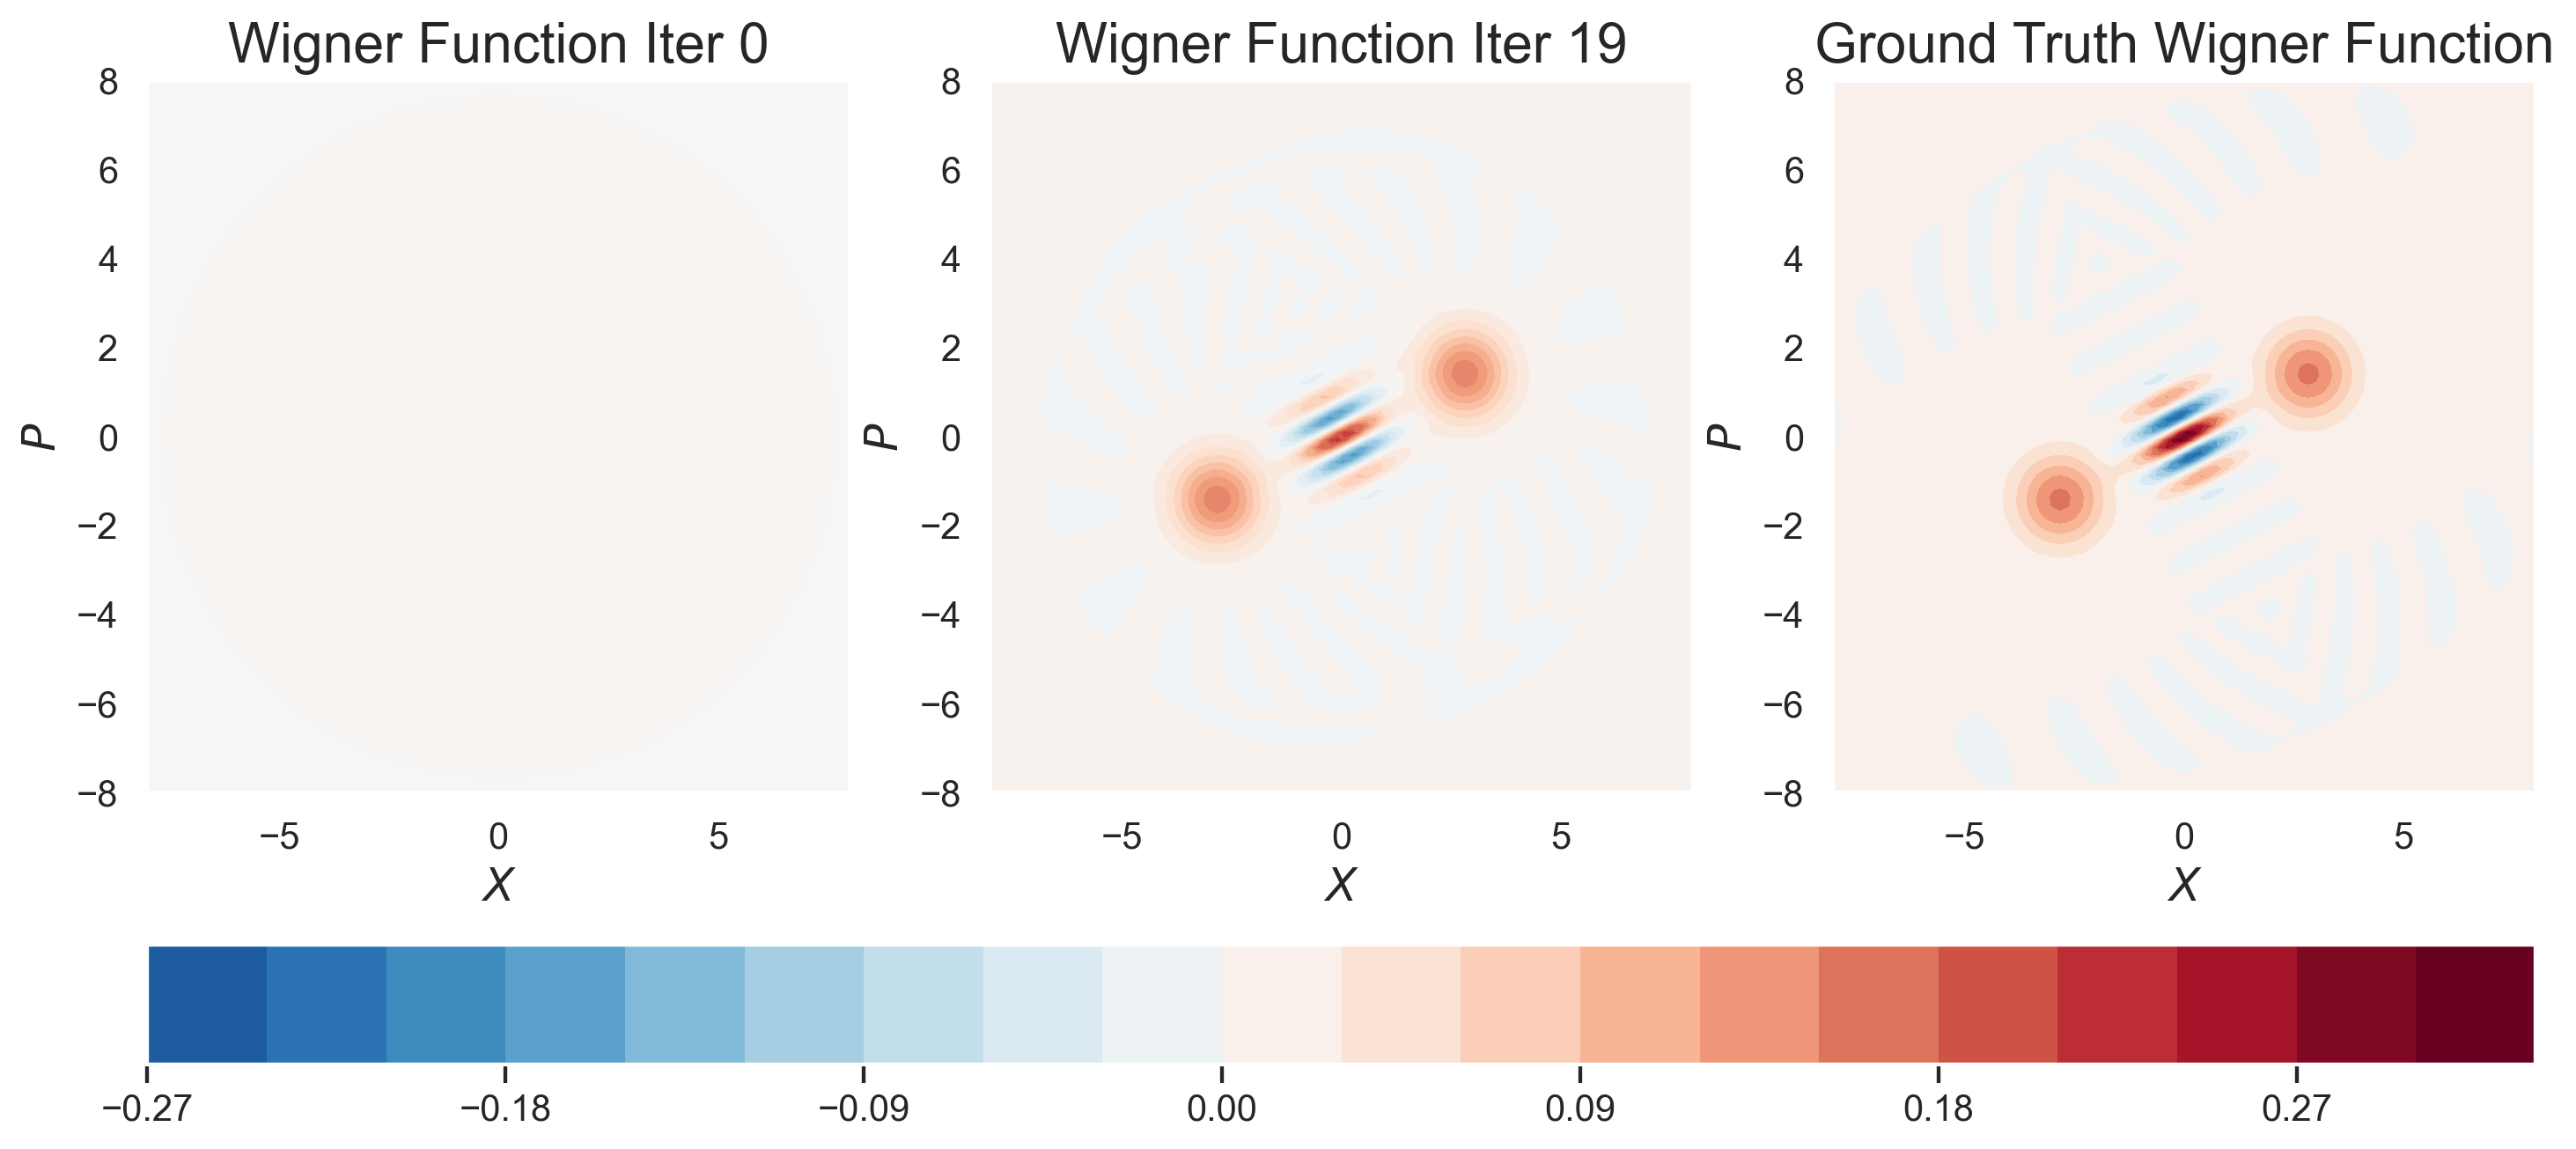

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6), dpi=250)
xvec = np.linspace(-8, 8, len(wigner_functions[0]))
yvec = np.linspace(-8, 8, len(wigner_functions[0]))
method = "laguerre"

gt_wigner = qt.wigner(qt.ket2dm(groundtruth), xvec, yvec, method=method)

cmap = "RdBu_r"
vmax = max(gt_wigner.max(), *[w.max() for w in wigner_functions])
# vmin = min(gt_wigner.min(), *[w.min() for w in wigner_functions])
vmin = - vmax
levels = 20


ax[0].contourf(xvec, yvec, wigner_functions[0], levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0].set_title("Wigner Function Iter 0")

ax[1].contourf(xvec, yvec, wigner_functions[20], levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)
ax[1].set_title("Wigner Function Iter 19")

c = ax[2].contourf(xvec, yvec, gt_wigner, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)
ax[2].set_title("Ground Truth Wigner Function")


# set axis labels for all
for a in ax:
    a.set_xlabel("$X$")
    a.set_ylabel("$P$")

fig.colorbar(c, ax=ax, orientation="horizontal",)

fig.savefig(f"plots/wigner_comparison_{state_type}_recon_stationary.png", dpi=250)


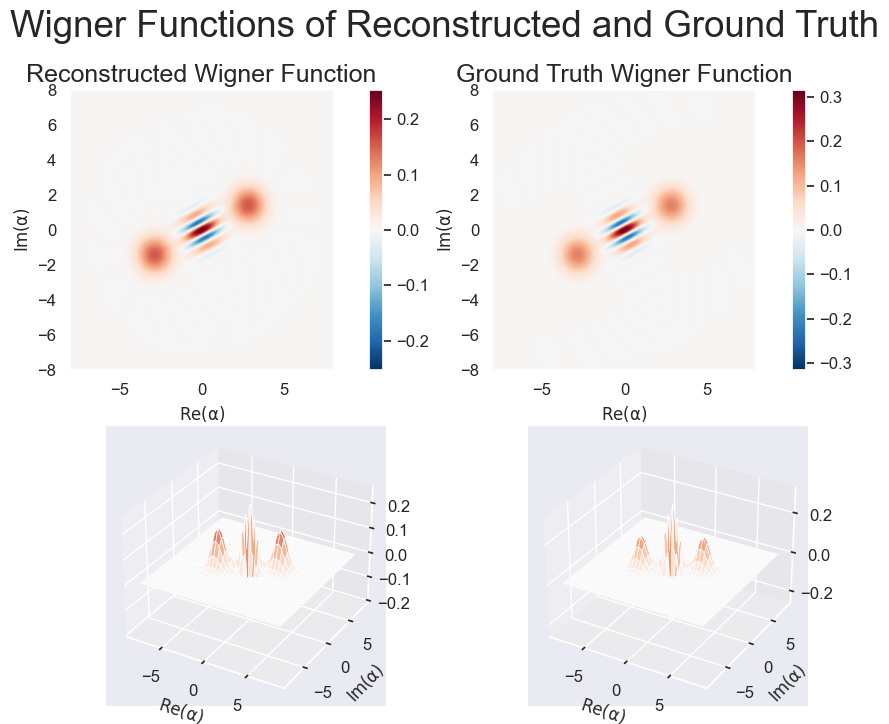

In [39]:
fig = plt.figure(figsize=(10, 8))

cmap = "RdBu_r"
xvec = np.linspace(-8, 8, 200)
yvec = np.linspace(-8, 8, 200)
method = "laguerre"

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223, projection="3d")
ax4 = fig.add_subplot(224, projection="3d")
qt.plot_wigner(recon, fig=fig, ax=ax1, cmap=cmap, xvec=xvec, yvec=yvec, projection="2d", method=method, colorbar=True)
qt.plot_wigner(groundtruth, fig=fig, ax=ax2, cmap=cmap, xvec=xvec, yvec=yvec, projection="2d", method=method, colorbar=True)
qt.plot_wigner(recon, fig=fig, ax=ax3, cmap=cmap, xvec=xvec, yvec=yvec, projection="3d", method=method)
qt.plot_wigner(groundtruth, fig=fig, ax=ax4, cmap=cmap, xvec=xvec, yvec=yvec, projection="3d", method=method)


ax1.set_title("Reconstructed Wigner Function")
ax2.set_title("Ground Truth Wigner Function")

fig.suptitle("Wigner Functions of Reconstructed and Ground Truth", )


figname = f"plots/reconstruction_comparison_wigner_{state_type}.png"
fig.savefig(figname)
